In [ ]:
import os
seed = 40
os.environ['PYTHONHASHSEED']=str(seed)

import random
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import *
#style.use('ggplot')
import pandas as pd
import numpy as np
import time
import torch.profiler
import torch.autograd.profiler as profiler
from scipy import stats as st
import sklearn.preprocessing as preprocess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
import torch.optim as optim
import optuna



random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Context Integrated RNN - CiRNN

In [ ]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class ContextGRU(torch.nn.Module):
    """
     simple GRU cell network
    """

    def __init__(self, input_dim, hidden_dim, output_dim, context_dim):
        super(ContextGRU, self).__init__()

        self.n_x = input_dim
        self.n_h = hidden_dim
        self.n_y = output_dim
        self.n_z = context_dim
        self.m = 9  #dimension of basis function vector (polynomial features) for 3 context features


        # reset gate components
        self.linear_reset_w1 = nn.Linear(self.n_x * self.m, self.n_h, bias=True)
        self.linear_reset_r1 = nn.Linear(self.n_h, self.n_h, bias=True)


        self.linear_reset_w2 = nn.Linear(self.n_x * self.m, self.n_h, bias=True)
        self.linear_reset_r2 = nn.Linear(self.n_h, self.n_h, bias=True)
        self.activation_1 = nn.Sigmoid()

        # update gate components
        self.linear_gate_w3 = nn.Linear(self.n_x * self.m, self.n_h, bias=True)
        self.linear_gate_r3 = nn.Linear(self.n_h, self.n_h, bias=True)
        self.activation_2 = nn.Sigmoid()

        self.activation_3 = nn.Tanh()

        #output
        self.linear_output = nn.Linear(self.n_h, self.n_y, bias=True)


    def reset_gate(self, xg, h):  #xg is the kronecker product of x and  basis function G(z)
        x_1 = self.linear_reset_w1(xg)
        h_1 = self.linear_reset_r1(h)
        # gate update
        r = self.activation_1(x_1 + h_1)
        return r

    def update_gate(self, xg, h):
        x_2 = self.linear_reset_w2(xg)
        h_2 = self.linear_reset_r2(h)
        s = self.activation_2( h_2 + x_2)
        return s


    def update_component(self, xg, h, r):
        x_3 = self.linear_gate_w3(xg)
        h_3 = r * self.linear_gate_r3(h)
        h_tilda = self.activation_3(x_3+h_3)
        return h_tilda


    def compute_output(self,h):
        y_pred = self.linear_output(h)
        return y_pred


    def cell_forward(self, x, h, G):

        """
        Implements a single forward step of the Context GRU-cell

        Input Arguments:
            x (mini-batch): input x at time step t , (n,n_x) : (batch_size, input_dim)
            h : hidden state at time step t-1, (n,n_h) : (batch_size, hidden_dim)
            G : vector of basis funcitons (m,n)

        Returns:
            h_new: hidden state at time step t, (n,n_h)

        """

        # kronecker product of x and G(zt)
        n = x.shape[0]
        xg = torch.zeros(n,self.n_x*self.m).to(device)

        for i in range(n):

            xg[i,:] = torch.kron(x[i,:],G[:,i])


        # Equation 1. reset gate vector
        r = self.reset_gate(xg, h)

        # Equation 2: the update gate - the shared update gate vector z
        s = self.update_gate(xg, h)

        # Equation 3: The almost output component
        h_tilda = self.update_component(xg,h,r)

        # Equation 4: the new hidden state
        h_new = (1-s) * h_tilda  + s * h

        #output

        y_pred = self.compute_output(h)

        return h_new, y_pred


    def forward(self, x, z):

        """
        Implement the forward propagation of the recurrent neural network

        Input Arguments:
        x (mini_batch): primary input for every time-step in mini-batches of shape (n, T, n_x)
        z (mini_batch): context input for every time-step in mini-batches of shape (n,T,n_z)


        Returns:
            h -- Hidden states for every time-step, numpy array of shape (n, T, n_h)
            y_pred -- Predictions for every time-step, numpy array of shape (n, T, n_y),
            here T is 1 for Seq to Vec RNN
        """

        # Retrieve dimensions from shapes of x
        #print(x.shape)
        #print(z.shape)
        n,T,n_x = x.shape
        n_y = self.n_y
        n_h = self.n_h
        n_z = self.n_z



        # initialize "h"

        h = self.init_hidden(n,T,n_h)

        #y_pred = np.zeros((m,T_x,n_y))
        #y_pred is single value for one sample, m=1

        #basis function vector
        G = self.apply_basis(z[:,0,:])  #G: size of (n,m)

        #for initial time step the hidden state is 0
        h_temp = h.clone()
        h_init = h_temp[:,0,:]
        h_curr, y_curr = self.cell_forward(x[:,0,:],h_init,torch.t(G))

        # loop over all time-steps
        for t in range(1,T):

            #compute the vector of basis functions

            G = self.apply_basis(z[:,t,:])  #G: size of (n,m)

            # Update next hidden state
            # ignore yt_pred for seq to vector
            h[:,t,:]= h_curr
            h_temp = h.clone()
            h_prev = h_temp[:,t,:]  #h_prev: (n,n_h)
            h_curr, y_curr = self.cell_forward(x[:,t,:],h_prev, torch.t(G))

            #y_pred[t,:] = yt_pred


        #compute the predicted output from the last cell i.e at last time step T
        y_pred = torch.zeros(n,1,1,device = 'cuda:0')

        #get the value of y_pred from the last cell
        y_pred[:,0,:] = y_curr

        #print(y_pred.shape)



        return h, y_pred


    def init_hidden(self, n:int,T:int, n_h:int):
        #initialise the hidden state
        #n : batch-size
        #T : Input sequence length
        #returns h of size (n,T,n_h)
        return torch.zeros(n,T,n_h,device = 'cuda:0')


    def apply_basis(self,zt):
        '''
        apply the basis function: polynomial degree 2
        [z0, z1, z2, z0z0, z0z1, z0z2....]
        input arguments:
            zt: context vector (n,n_z) for mini-batch of size n and n_z context dim
        Returns:
            G : tensor of basis functions, (m,n)

        for 3 context features m = 9
        '''

        #poly = PolynomialFeatures(2, include_bias=False, interaction_only=True)
        poly = PolynomialFeatures(2, include_bias=False)
        G = torch.tensor(poly.fit_transform(zt.cpu().numpy())).to(device) #fit_transform returns nd array




        return G




Using cuda device


In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.weights = []      #used for visualising weights
        self.settings = []     #saving settings for visualising weights
        self.inputs = []       #saving input for visualising

    def train_step(self, x, y, z):

       # with profiler.record_function("TRAIN STEP FUNCTION"):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        h, yhat = self.model(x, z)


        # Computes loss
        loss = self.loss_fn(y, yhat)

        #with profiler.record_function("LOSS_BACKWARD"):
        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss

        return loss.item()

    def train(self, train_loader, val_loader, batch_size, n_epochs=50, np_features=1, nc_features=1):
        '''
        np_features = # primary input features
        nc_features = # context input features
        '''
        #model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        times = []
        for epoch in range(1, n_epochs + 1):

            start_epoch = time.time()

            batch_losses = []
            batch_count = 0
            for x_batch, z_batch, y_batch in train_loader:
                batch_count += 1
                x_batch = x_batch.view([batch_size,-1, np_features]).to(device)
                y_batch = y_batch.to(device)
                z_batch = z_batch.view([batch_size,-1, nc_features]).to(device)

                #with profiler.profile(with_stack=True, profile_memory=True) as prof:
                loss = self.train_step(x_batch, y_batch, z_batch)
                #print(prof.key_averages(group_by_stack_n=5).table(sort_by = 'self_cpu_time_total', row_limit = 5))

                batch_losses.append(loss)

            # if (epoch % 10 == 0):
            #         #if (batch_count % 200 == 0):
            #             #save the model weights for each batch for analysis
            #             #self.save_model(self.model, batch_count, str(z_batch[-1,:,:].detach().cpu().numpy()))
            #     for param_tensor in model.state_dict():
            #         if (param_tensor == 'linear_reset_w1.weight'):
            #             param_val = model.state_dict()[param_tensor].cpu().numpy().tolist()
            #             self.weights.append(param_val)
            #             self.settings.append(z_batch[-1,:,:].detach().cpu().numpy().tolist())
            #self.model.to(device)


            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)




            with torch.no_grad():
                batch_val_losses = []
                for x_val, z_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, np_features]).to(device, non_blocking=True)
                    y_val = y_val.to(device)
                    z_val = z_val.view([batch_size, -1, nc_features]).to(device,non_blocking=True)
                    self.model.eval()

                    # with profiler.profile(with_stack=True, profile_memory=True) as prof:
                    h,yhat = self.model(x_val, z_val)
                    # print(prof.key_averages(group_by_stack_n=5).table(sort_by = 'self_cpu_time_total', row_limit = 5))

                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch % 5 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )



            torch.cuda.synchronize()
            end_epoch = time.time()
            elapsed = end_epoch - start_epoch
            times.append(elapsed)

        total_time = sum(times)
        avg_time = sum(times)/n_epochs

        print(f"Average Training time: {avg_time:.4f} s for epochs {n_epochs}")

        print(f"Total Training time: {total_time:.4f} s for epochs {n_epochs}")


        #torch.save(self.model.state_dict(), model_path)

        return validation_loss  #this will be used by otuna to optimize

    def evaluate(self, test_loader, batch_size=1, np_features=1, nc_features = 1):
            with torch.no_grad():
                predictions = []
                values = []
                for x_test, z_test, y_test in test_loader:

                    x_test = x_test.view([batch_size,-1, np_features]).to(device, non_blocking=True)
                    y_test = y_test.to(device)
                    z_test = z_test.view([batch_size,-1, nc_features]).to(device, non_blocking=True)
                    self.model.eval()
                    h,yhat = self.model(x_test, z_test)
                    predictions.append(yhat.detach().cpu().numpy())
                    values.append(y_test.detach().cpu().numpy())

            return predictions, values

    def plot_losses(self):
            plt.plot(self.train_losses, label="Training loss")
            plt.plot(self.val_losses, label="Validation loss")
            plt.legend()
            plt.title("Losses")
            plt.xlabel("Epochs")
            plt.ylabel("Loss(MSE)")
            plt.show()
            plt.close()

    # def save_model(self, model, batch_id, settings_val):

    #     path = r'/home/rashmi/PythonProjects/codes/TURBOFAN_MODELS/savedmodels/'
    #     #save model
    #     file_name = 'FD002_Params.txt'
    #     file_path = os.path.join(path,file_name)
    #     f = open(file_path, 'a')
    #     f.write('Batch'+ str(batch_id)+'\n')
    #     f.write('-------\n')
    #     for param_tensor in model.state_dict():
    #         param_val = model.state_dict()[param_tensor].cpu().numpy().tolist()
    #         f.write(param_tensor + "\t" + str(param_val))
    #         f.write('\n---------------\n')
    #     f.write('Settings\n')
    #     f.write(settings_val + '\n')
    #     f.write('---------------\n')
    #     f.write('\n')

    #     f.close()


    def visualise_weights(self):

#         col = ['r','b','g']
#         nrows = len(self.weights)
#         for i in range(nrows):
#             wtmatrix = np.array(self.weights[i])
#             print(wtmatrix.shape)
#             fig = plt.figure()
#             print(wtmatrix[0:9, 0:9])
#             #plt.imshow(wtmatrix[0:9, 0:9])
#             sns.heatmap(wtmatrix[0:10, 0:10])

#         fig = plt.figure()
#         for i in range(nrows):
#             wtmatrix = np.array(self.weights[i])
#             plt.plot(wtmatrix[0:10],wtmatrix [0:10],color = col[i],marker = '.')

        return self.weights, self.settings, self.inputs





## 1. Data Loading

In [ ]:
#data load function
#4 sets of data: FD001, FD002, FD003, FD004
#FD001 and FD003 same operating condition 1
#FD002 and FD004 same operating condition 6

def dataload(filename):

    df = pd.read_csv(filename)
    return df

In [ ]:
# define path for the data
#path =

In [ ]:
train_FD002 = dataload(path+'train_FD002')
test_FD002 = dataload(path+'test_FD002')
#train_FD002.head()

In [ ]:
#drop the frst unnamed column
train_FD002.drop(columns = train_FD002.columns[0],axis=1, inplace=True)
test_FD002.drop(columns = test_FD002.columns[0],axis=1, inplace=True)
train_FD002.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,125
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,125
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,125
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,125
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,125


## 2. Data Prepreprocessing

### a) Smoothing - moving average

In [ ]:
#Trailing moving average
#trail_ma(t) = mean(obs(t-2), obs(t-1), obs(t))

def moving_average(x, w):
    #x: time series
    #w: sliding window size
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
feature_list = ['unit_number','time_cycles','setting_1','setting_2','setting_3',
                's_1','s_2','s_8','s_13','s_14','s_19','RUL']

### b) Normalisation - Transform and Inverse transform

In [ ]:
def data_transform(data,option ='std'):
#data is numpy array
#option is set to std for standardization or minmax

    n = data.shape[0]

    if option == 'std' :

        #perform standardization of data
        miu = np.mean(data,axis = 0)
        sigma = np.std(data,axis=0,dtype=float)
        temp_data = data-np.tile(miu,(n,1))
        std_data = np.divide(temp_data,np.tile(sigma,(n,1)))

        return std_data, miu, sigma

    elif option == 'minmax':

        #perform min-max normalization
        max_val = np.max(data,0)
        #print(max_val)
        min_val = np.min(data,0)
        #print(min_val)
        rng = max_val-min_val
        norm_data = np.divide(data - np.tile(min_val,(n,1)),np.tile(rng,(n,1)))

        return norm_data, min_val, rng

In [ ]:
## Inverse transform the target/outout data from normalized to original

def inv_trans(data,option,param1, param2):
    # apply inverse of standardization or normalization for 1-D column/row vector
    # option: standard or minmax normalization
    # params:list of parameters applied while normalization
    # data is 1-D column vector
#     print(data)
#     print(param1)
#     print(param2)

    if option == "std":
         #perform standardization of data
        miu = param1
        sigma = param2
        inv_data = data*sigma + miu

        return inv_data

    else : #MinMax normalization

        #perform min-max normalization
        min_val = param1
        rng = param2
        inv_data = data*rng+min_val
        return inv_data

### c) Clustering and Normalization

In [ ]:
from sklearn.cluster import KMeans

feature_list = ['unit_number','time_cycles','setting_1','setting_2','setting_3','s_1','s_2','s_8','s_13','s_14','s_19', 'RUL']
select_data_train = np.array(train_FD002[feature_list].copy(deep=True))
train_data, p1, p2 = data_transform(select_data_train[:,2:],option = 'minmax') #drop unit_number and time_cycles

kmeans = KMeans(n_clusters=6, n_init=10, random_state=0).fit(train_data)

#kmeans.labels_
#kmeans.predict([[0, 0], [12, 3]])
#kmeans.cluster_centers_

In [ ]:
col_names = ['setting_1','setting_2','setting_3','s_1','s_2','s_8', 's_13','s_14','s_19','RUL']
#del train_data_cluster

train_data_cluster = train_FD002[['unit_number','time_cycles']].copy(deep=True)
train_data_cluster[col_names] = pd.DataFrame(train_data, columns = col_names)
train_data_cluster['label'] = kmeans.labels_.astype(str)
print(train_data_cluster.shape)

(53759, 13)


### Train data normalisation with cluster centers

In [ ]:
'''
Normalize train data using the clusters of operational settings
'''
def cluster_norm(clustered_data,opt='minmax'):
#input: clustered data - data frame, option: minmax or std (z-score)
#output: normalised data, parameter 1: miu/min value, parameter 2: sigma/range
#col_names = ['unit_number','time_cycle',setting_1','setting_2','setting_3','s_1','s_2','s_8',
#            's_13','s_14','s_19','RUL','label']

    n = clustered_data.shape[0]
    norm_data = clustered_data.copy(deep = True)


    col_names = ['setting_1','setting_2','setting_3','s_1','s_2','s_8', 's_13','s_14','s_19']

    if opt == 'std':
        #get the standard deviation of each cluster
        clust_sigma = []
        clust_miu = []
        for i in range(6):  #6 is number of clusters
            idx = clustered_data[clustered_data['label']==str(i)].index
            cluster = clustered_data[clustered_data['label']==str(i)].copy(deep = True)
            sigma = cluster[col_names].std(axis=1)
            miu = cluster[col_names].mean(axis=1)
            for j in range(len(col_names)):  #if max and min values are same then cluster column has same values
                if (sigma[col_names[j]] == 0):
                    sigma[col_names[j]] = 1
                    miu[col_names[j]] = 0
            df_norm = (cluster-miu)/sigma
            #norm_data.loc[idx.tolist(),2:11] = df_norm
            norm_data.loc[clustered_data['label']==str(i),col_names] = df_norm
            clust_sigma.append(sigma)
            clust_miu.append(miu)


        return norm_data, clust_miu, clust_sigma


    elif opt == 'minmax':

        clust_min = []
        clust_range = []

        for i in range(6):
            cluster = clustered_data[clustered_data['label']==str(i)].copy(deep = True)
            #print(cluster.head())
            min_val = cluster[col_names].min(axis=0)
            max_val = cluster[col_names].max(axis=0)
            range_val = max_val-min_val
            for j in range(len(col_names)):  #if max and min values are same then cluster column has same values
                if (range_val[col_names[j]] == 0):
                    range_val[col_names[j]] = 1
                    min_val[col_names[j]] = 0
            df_norm = (cluster[col_names]-min_val)/range_val
            #print(df_norm.head())
            #idx = clustered_data[clustered_data['label']==str(i)].index
            #norm_data.iloc[idx.tolist(),2:11] = df_norm
            norm_data.loc[clustered_data['label']==str(i),col_names]=df_norm
            clust_min.append(min_val)
            clust_range.append(range_val)

        return norm_data, clust_min, clust_range

In [1]:
# train_norm_data, param1, param2 = cluster_norm(train_data_cluster,'minmax')
# print(train_norm_data.head())

### Test data normalisation with cluster centers of train data

In [2]:
'''
Normalize the test data using the train data cluster statistics
'''
col_names = ['setting_1','setting_2','setting_3','s_1','s_2','s_8', 's_13','s_14','s_19','RUL']
col_names1 = ['setting_1','setting_2','setting_3','s_1','s_2','s_8', 's_13','s_14','s_19']

#1. Normalize using training data statistics
select_data_test = test_FD002[col_names].copy(deep=True)

#perform min-max normalization
min_val = p1
rng = p2
#norm_data = (smooth_data_test[:,2:]-min_val)/rng
norm_data = (select_data_test-min_val)/rng
#print(norm_data[0:5,0])

#2. Predict the labels using kmeans model of training data

labels = kmeans.predict(norm_data)
test_data_cluster = test_FD002[['unit_number','time_cycles']].copy(deep = True)
#test_data_cluster = pd.DataFrame(select_data_test[:,0:2],columns = ['unit_number','time_cycles'])
test_data_cluster[col_names] = norm_data
test_data_cluster['label'] = labels
#print(test_data_cluster.head())

#3. Normalise using cluster statistics
clustered_data = test_data_cluster.copy(deep=True)

for i in range(6):
    cluster = clustered_data[clustered_data['label']== i].copy(deep = True)
    #print(cluster.head())
    min_val1 = param1[i]
    range_val1 = param2[i]
    df_norm = (cluster[col_names]-min_val1)/range_val1
    #print(df_norm.head())
    idx = clustered_data[clustered_data['label']== i].index
    #clustered_data.iloc[idx.tolist(),2:11] = 100
    clustered_data.loc[clustered_data['label']== i,col_names1] = df_norm


test_norm_data = clustered_data.copy(deep = True)

print(test_norm_data.head())


### Smoothing the cluster normalised data

In [ ]:
# print(train_norm_data.head())
# print(test_norm_data.head())
feature_list = ['unit_number','time_cycles','setting_1','setting_2','setting_3',
                's_1','s_2','s_8','s_13','s_14','s_19','RUL']
#smooth the normalised data
# train_data = np.array(train_FD002[feature_list])
# (n,m) = train_data.shape
# print(train_data[0:4,:])

train_data = np.array(train_norm_data[feature_list].copy(deep = True))

w = 3   #window size for moving average smoothing

#Apply data smoothing separately to each engine unit data group
unit_numbers = train_FD002['unit_number'].unique()

#for unit number 1
grp_data = train_data[train_data[:,0] == 1]
(n,m) = grp_data.shape
smooth_data_train = np.zeros((n-w+1,m))  #array to store smooth data
smooth_data_train[:,0:2] = grp_data[(w-1):,0:2]  #copy unit number and  time_cycle
smooth_data_train[:,11] = grp_data[(w-1):,11] #copy RUL
#print(smooth_data[0:4,:])

for i in range(9): #6 sensors + 3 settings
    series = grp_data[:,i+2]
    smooth_series = moving_average(series,w)
    smooth_data_train[:,i+2] = smooth_series

unit_numbers = unit_numbers[1:]
#for remaining unit numbers
for i in unit_numbers:
    grp_data = train_data[train_data[:,0] == i]
    (n,m) = grp_data.shape
    smooth_data_train1= np.zeros((n-w+1,m))  #array to store smooth data
    smooth_data_train1[:,0:2] = grp_data[(w-1):,0:2]  #copy unit number, time_cycle, and 3 settings
    smooth_data_train1[:,11] = grp_data[(w-1):,11] #copy RUL
    #print(smooth_data[0:4,:])

    for i in range(9): #21 sensors+3 settings
        series = grp_data[:,i+2]
        smooth_series = moving_average(series,w)
        smooth_data_train1[:,i+2] = smooth_series

    smooth_data_train = np.concatenate((smooth_data_train,smooth_data_train1), axis = 0)


print(smooth_data_train.shape)

#plot smooth data for selected engine unit

# data = smooth_data_train[smooth_data_train[:,0] == 100]
# #print(data[0:5,:])

# plt.figure(figsize=(20, 10))
# for i in range(2,11):
#     plt.subplot(3, 3, i-1).set_title(feature_list[i])
#     plt.plot(data[:,1], data[:,i])
#     plt.tight_layout()


(53239, 12)


In [ ]:
# print(train_norm_data.head())
# print(test_norm_data.head())
feature_list = ['unit_number','time_cycles','setting_1','setting_2','setting_3',
                's_1','s_2','s_8','s_13','s_14','s_19','RUL','label']
#smooth the normalised data
# train_data = np.array(train_FD002[feature_list])
# (n,m) = train_data.shape
# print(train_data[0:4,:])

test_data = np.array(test_norm_data[feature_list].copy(deep = True))

w = 3   #window size for moving average smoothing

#Apply data smoothing separately to each engine unit data group
unit_numbers = test_FD002['unit_number'].unique()

#for unit number 1
grp_data = test_data[test_data[:,0] == 1]
(n,m) = grp_data.shape
smooth_data_test = np.zeros((n-w+1,m))  #array to store smooth data
smooth_data_test[:,0:2] = grp_data[(w-1):,0:2]  #copy unit number and  time_cycle
smooth_data_test[:,11] = grp_data[(w-1):,11] #copy RUL
smooth_data_test[:,12] = grp_data[(w-1):,12] #copy label
#print(smooth_data[0:4,:])

for i in range(9): #6 sensors + 3 settings
    series = grp_data[:,i+2]
    smooth_series = moving_average(series,w)
    smooth_data_test[:,i+2] = smooth_series

unit_numbers = unit_numbers[1:]
#for remaining unit numbers
for i in unit_numbers:
    grp_data = test_data[test_data[:,0] == i]
    (n,m) = grp_data.shape
    smooth_data_test1= np.zeros((n-w+1,m))  #array to store smooth data
    smooth_data_test1[:,0:2] = grp_data[(w-1):,0:2]  #copy unit number, time_cycle, and 3 settings
    smooth_data_test1[:,11] = grp_data[(w-1):,11] #copy RUL
    smooth_data_test1[:,12] = grp_data[(w-1):,12] #copy label
    #print(smooth_data[0:4,:])

    for i in range(9): #21 sensors+3 settings
        series = grp_data[:,i+2]
        smooth_series = moving_average(series,w)
        smooth_data_test1[:,i+2] = smooth_series

    smooth_data_test = np.concatenate((smooth_data_test,smooth_data_test1), axis = 0)


print(smooth_data_test.shape)

#plot smooth data for selected engine unit

# data = smooth_data_test[smooth_data_test[:,0] == 100]
# #print(data[0:5,:])

# plt.figure(figsize=(20, 10))
# for i in range(2,11):
#     plt.subplot(3, 3, i-1).set_title(feature_list[i])
#     plt.plot(data[:,1], data[:,i])
#     plt.tight_layout()


(33473, 13)


### d) Denormalization (target) - 2 levels

In [ ]:
# Inverse transform the target/outout data from normalized to original
# Note that there are two levels of denormalization

def d_norm(data,option,label,cparam1, cparam2, param1, param2):
    # apply inverse of standardization or normalization for 1-D column/row vector
    # option: standard or minmax normalization
    # param:parameters applied while normalization (training data statistics)
    # data is 1-D column vector
    # cparam: list of parameters for each cluster (cluster data statistics)

    #convert the vector to dataframe and add labels
    target = pd.DataFrame(data, columns = ['actual'])
    target['label'] = label
    inv_data = target.copy(deep = True)
    #print(inv_data.head())



    if option == "std":  #z-score denormalization

        for i in range(6):   #for 6 clusters
            cluster = inv_data[inv_data['label']== i].copy(deep = True)
            #print(cluster.head())
            miu = cparam1[i]['RUL']
            sigma = cparam2[i]['RUL']
            df_norm = cluster['actual']*sigma+miu
            #print(df_norm.head())
            #idx = inv_data[inv_data['label']== i].index
            #inv_data.iloc[idx.tolist(),0] = df_norm
            inv_data.loc[inv_data['label']== i,'actual'] = df_norm

        miu = param1
        sigma = param2
        inv_data1 = inv_data['actual']*sigma+miu


    else : #MinMax denormalization

        for i in range(6):
            cluster = inv_data[inv_data['label']== i].copy(deep = True)
            #print(cluster.head())
            min_val = cparam1[i]['RUL']
            range_val = cparam2[i]['RUL']
            df_norm = cluster['actual']*range_val+min_val
            #print(df_norm.head())
            idx = inv_data[inv_data['label']== i].index
            inv_data.loc[inv_data['label']== i,'actual'] = df_norm

        m = param1
        r = param2
        inv_data1 = inv_data['actual']*r+m

    #print (inv_data1.to_numpy())

    return inv_data1.to_numpy()

### d) Denormalization (target) - 1 level

In [ ]:
# Inverse transform the target/outout data from normalized to original

def d_norm_1(data,option,param1, param2):
    # apply inverse of standardization or normalization for 1-D column/row vector
    # option: standard or minmax normalization
    # param:parameters applied while normalization (training data statistics)
    # data is 1-D column vector



    if option == "std":  #z-score denormalization


        miu = param1
        sigma = param2
        inv_data1 = data*sigma+miu


    else : #MinMax denormalization

            m = param1
            r = param2
            inv_data1 = data*r+m

    #print (inv_data1.to_numpy())

    return inv_data1

### Minmax normalisation and smoothing

In [ ]:
#Train data normalisation and smoothing
feature_list = ['unit_number','time_cycles','setting_1','setting_2','setting_3','s_1','s_2','s_8','s_13','s_14','s_19', 'RUL']
select_data_train = np.array(train_FD002[feature_list].copy(deep=True))
train_data, p1, p2 = data_transform(select_data_train[:,2:],option = 'minmax') #drop unit_number and time_cycles

#add unit_number and time_cycles to train_data
train_data = np.concatenate((select_data_train[:,0:2], train_data),axis = 1)

w = 3   #window size for moving average smoothing

#Apply data smoothing separately to each engine unit data group
unit_numbers = train_FD002['unit_number'].unique()

#for unit number 1
grp_data = train_data[train_data[:,0] == 1]
(n,m) = grp_data.shape
smooth_data_train = np.zeros((n-w+1,m))  #array to store smooth data
smooth_data_train[:,0:2] = grp_data[(w-1):,0:2]  #copy unit number and  time_cycle
smooth_data_train[:,11] = grp_data[(w-1):,11] #copy RUL
#print(smooth_data[0:4,:])

for i in range(9): #6 sensors + 3 settings
    series = grp_data[:,i+2]
    smooth_series = moving_average(series,w)
    smooth_data_train[:,i+2] = smooth_series

unit_numbers = unit_numbers[1:]
#for remaining unit numbers
for i in unit_numbers:
    grp_data = train_data[train_data[:,0] == i]
    (n,m) = grp_data.shape
    smooth_data_train1= np.zeros((n-w+1,m))  #array to store smooth data
    smooth_data_train1[:,0:2] = grp_data[(w-1):,0:2]  #copy unit number, time_cycle, and 3 settings
    smooth_data_train1[:,11] = grp_data[(w-1):,11] #copy RUL
    #print(smooth_data[0:4,:])

    for i in range(9): #21 sensors+3 settings
        series = grp_data[:,i+2]
        smooth_series = moving_average(series,w)
        smooth_data_train1[:,i+2] = smooth_series

    smooth_data_train = np.concatenate((smooth_data_train,smooth_data_train1), axis = 0)


print(smooth_data_train.shape)

#plot smooth data for selected engine unit

# data = smooth_data_train[smooth_data_train[:,0] == 100]
# #print(data[0:5,:])

# plt.figure(figsize=(20, 10))
# for i in range(2,11):
#     plt.subplot(3, 3, i-1).set_title(feature_list[i])
#     plt.plot(data[:,1], data[:,i])
#     plt.tight_layout()



(53239, 12)


In [ ]:
#Test data normalisation and smoothing
#1. Normalize using training data statistics
select_data_test = np.array(test_FD002[feature_list].copy(deep=True))

#perform min-max normalization
min_val = p1
rng = p2
test_data = (select_data_test[:,2:]-min_val)/rng

#add unit_number and time_cycle
test_data = np.concatenate((select_data_test[:,0:2], test_data),axis = 1)

w = 3   #window size for moving average smoothing

#Apply data smoothing separately to each engine unit data group
unit_numbers = test_FD002['unit_number'].unique()

#for unit number 1
grp_data = test_data[test_data[:,0] == 1]
(n,m) = grp_data.shape
smooth_data_test = np.zeros((n-w+1,m))  #array to store smooth data
smooth_data_test[:,0:2] = grp_data[(w-1):,0:2]  #copy unit number and  time_cycle
smooth_data_test[:,11] = grp_data[(w-1):,11] #copy RUL

for i in range(9): #6 sensors + 3 settings
    series = grp_data[:,i+2]
    smooth_series = moving_average(series,w)
    smooth_data_test[:,i+2] = smooth_series

unit_numbers = unit_numbers[1:]
#for remaining unit numbers
for i in unit_numbers:
    grp_data = test_data[test_data[:,0] == i]
    (n,m) = grp_data.shape
    smooth_data_test1= np.zeros((n-w+1,m))  #array to store smooth data
    smooth_data_test1[:,0:2] = grp_data[(w-1):,0:2]  #copy unit number, time_cycle, and 3 settings
    smooth_data_test1[:,11] = grp_data[(w-1):,11] #copy RUL


    for i in range(9): #21 sensors+3 settings
        series = grp_data[:,i+2]
        smooth_series = moving_average(series,w)
        smooth_data_test1[:,i+2] = smooth_series

    smooth_data_test = np.concatenate((smooth_data_test,smooth_data_test1), axis = 0)


print(smooth_data_test.shape)

#plot smooth data for selected engine unit

# data = smooth_data_test[smooth_data_test[:,0] == 100]
# #print(data[0:5,:])

# plt.figure(figsize=(20, 10))
# for i in range(2,11):
#     plt.subplot(3, 3, i-1).set_title(feature_list[i])
#     plt.plot(data[:,1], data[:,i])
#     plt.tight_layout()


(33473, 12)


## 3. Data Preparation

In [ ]:
# Prepare the data for RNN model such that the data is presented as (num_samples,seq_length,num_features)

def data_preparation(data,n_past,n_future):
    '''
    input:
        data :[unit_number, time_cycles,context inputs, primary inputs, output]
        n_past : number of past steps to be used for prediction
        n_future :  number of steps ahead

    returns:
        context input (Z): 'setting_1','setting_2', 'setting_3'
        primary input (X): 's_1','s_2','s_8','s_13','s_14','s_19'
        ouput/target (Y): 'RUL' at time step t
        Engine unit and time cycles (U)
    '''

    n,m = data.shape


    k = n_future
    t = n_past


    input_data = []
    output_data = []
    context_data = []
    engine_data = []


    for i in range(t, (n-k+1)):

        engine_data.append(data[i-t:i,0:2])  # first two are unit_number, time_cycles
        context_data.append(data[i-t:i,2:5]) # then settings data
        input_data.append(data[i-t:i, 5:m-1])  #next six attributes are sensor data
        output_data.append([data[i+k-1:i+k,m-1]])  #last column is the RUL



    U = np.array(engine_data)
    X = np.array(input_data)
    Y = np.array(output_data)
    Z = np.array(context_data)




    #print(n,m)
#    print(X.shape)
#     print(Y.shape)
#     print(Z.shape)


    return U, X, Y, Z


In [ ]:
#for test set label is also provided

def data_preparation_test(data,n_past,n_future):

    '''
    input:
        data :[unit_number, time_cycles,context inputs, primary inputs, output, label]
        n_past : number of past steps to be used for prediction
        n_future :  number of steps ahead

    returns:
        context input (Z): 'setting_1','setting_2', 'setting_3'
        primary input (X): 's_1','s_2','s_8','s_13','s_14','s_19'
        ouput/target (Y): 'RUL' at time step t
        Engine unit and time cycles (U)
        label : label at time step t required for denormalisation of dat
    '''



    n,m = data.shape
    #print(n,m)

    k = n_future
    t = n_past


    input_data = []
    output_data = []
    context_data = []
    engine_data = []

    label_data = []


    for i in range(t, (n-k+1)):
        engine_data.append(data[i-t:i,0:2])        # first two are unit_number, time_cycles
        context_data.append(data[i-t:i,2:5])       # then settings data
        input_data.append(data[i-t:i, 5:m-2])      # next six attributes are sensor data
        output_data.append(data[i+k-1:i+k,m-2])    # second last column is the RUL
        label_data.append(data[i+k-1:i+k,m-1])     #last column is label


    U = np.array(engine_data)
    X = np.array(input_data)
    Y = np.array(output_data)
    Z = np.array(context_data)
    label = np.array(label_data)




    return U, X, Y, Z, label


### a) Data preparation Training and Validation data (cluster normalised)

In [ ]:
'''
prediction n_future = step ahead with n_past samples
NOTE: n_future is set to 0 as the predicted step will not be k step ahead it will be at t
unit_number is also present in columns, it will be used for selecting rows for validation set
sensor_list = ['s_1','s_2','s_8','s_13','s_14','s_19']
'''

'''
------------data normalised using cluster statistics----------------------------------------
'''

arr_data = train_norm_data.copy(deep = True)
arr_data.drop('label',axis=1, inplace = True)
# # print(arr_data.shape)
# # print(arr_data.head())
data = arr_data.to_numpy()
#print(smooth_data_train.shape)
#data = smooth_data_train

'''
The train and test data is availble. Divide the given train data into two parts train and validation,
considering the engine unit number.
'''
seq_len = 10 #sequence length for lstm


#take last rows equivalent to double the seq_len from each of the engine unit as validation data
list_unit = train_FD002['unit_number'].unique()
eng_data = data[data[:,0]==list_unit[0]]
data_train = eng_data[:-2*seq_len,:]
data_val = eng_data[-2*seq_len:,:]


for i in range(1,len(list_unit)):
    eng_data = data[data[:,0]==list_unit[i]]
    data_train = np.concatenate((data_train,eng_data[:-2*seq_len,:]), axis=0)
    data_val = np.concatenate((data_val,eng_data[-2*seq_len:,:]), axis=0)

# print(data_train.shape)
# print(data_val.shape)

#prepare the data for each engine unit grp separately
#X, Y, Z are 3 dim (num_samples,Sequence length, num_features)
grp_data = data_train[data_train[:,0] == 1]
U_train, X_train, Y_train, Z_train= data_preparation(grp_data,seq_len,1)  #last parameter 0 means context features excluded
grp_data = data_val[data_val[:,0]==1]
U_val, X_val, Y_val, Z_val = data_preparation(grp_data,seq_len,1)

# print(X_train.shape)
# print(X_val.shape)


list_unit = list_unit[1:]
for i in range(1,len(list_unit)):
    grp_data = data_train[data_train[:,0] == list_unit[i]]
    U_train1, X_train1, Y_train1, Z_train1 = data_preparation(grp_data,seq_len,1)
    grp_data = data_val[data_val[:,0]==i]
    U_val1, X_val1, Y_val1, Z_val1 = data_preparation(grp_data,seq_len,1)


    U_train = np.concatenate((U_train,U_train1),axis = 0)
    X_train = np.concatenate((X_train,X_train1),axis = 0)
    Y_train = np.concatenate((Y_train,Y_train1),axis = 0)
    Z_train = np.concatenate((Z_train,Z_train1),axis = 0)


    U_val = np.concatenate((U_val,U_val1),axis = 0)
    X_val = np.concatenate((X_val,X_val1),axis = 0)
    Y_val = np.concatenate((Y_val,Y_val1),axis = 0)
    Z_val = np.concatenate((Z_val,Z_val1),axis = 0)

print(X_train.shape)
print(Z_train.shape)
print(Y_train.shape)


(45720, 10, 6)
(45720, 10, 3)
(45720, 1, 1)


### b) Data preparation (min-max normalised and smooth data)

In [ ]:
'''
prediction n_future = step ahead with n_past samples
NOTE: n_future is set to 1 as the predicted step will not be k step ahead it will be at t+1
unit_number is also present in columns, it will be used for selecting rows for validation set
sensor_list = ['s_1','s_2','s_8','s_13','s_14','s_19']
'''

'''
------------minmax normalised data----------------------------------------
'''

data = smooth_data_train

'''
The train and test data is availble. Divide the given train data into two parts train and validation,
considering the engine unit number.
'''
seq_len = 20 #sequence length for lstm


#take last rows equivalent to double the seq_len from each of the engine unit as validation data
list_unit = train_FD002['unit_number'].unique()
eng_data = data[data[:,0]==list_unit[0]]
data_train = eng_data[:-2*seq_len,:]
data_val = eng_data[-2*seq_len:,:]


for i in range(1,len(list_unit)):
    eng_data = data[data[:,0]==list_unit[i]]
    data_train = np.concatenate((data_train,eng_data[:-2*seq_len,:]), axis=0)
    data_val = np.concatenate((data_val,eng_data[-2*seq_len:,:]), axis=0)

# print(data_train.shape)
# print(data_val.shape)

#prepare the data for each engine unit grp separately
#X, Y, Z are 3 dim (num_samples,Sequence length, num_features)
grp_data = data_train[data_train[:,0] == 1]
U_train, X_train, Y_train, Z_train= data_preparation(grp_data,seq_len,1)  #last parameter 0 means context features excluded
grp_data = data_val[data_val[:,0]==1]
U_val, X_val, Y_val, Z_val = data_preparation(grp_data,seq_len,1)

# print(X_train.shape)
# print(X_val.shape)


list_unit = list_unit[1:]
for i in range(1,len(list_unit)):
    grp_data = data_train[data_train[:,0] == list_unit[i]]
    U_train1, X_train1, Y_train1, Z_train1 = data_preparation(grp_data,seq_len,1)
    grp_data = data_val[data_val[:,0]==i]
    U_val1, X_val1, Y_val1, Z_val1 = data_preparation(grp_data,seq_len,1)


    U_train = np.concatenate((U_train,U_train1),axis = 0)
    X_train = np.concatenate((X_train,X_train1),axis = 0)
    Y_train = np.concatenate((Y_train,Y_train1),axis = 0)
    Z_train = np.concatenate((Z_train,Z_train1),axis = 0)


    U_val = np.concatenate((U_val,U_val1),axis = 0)
    X_val = np.concatenate((X_val,X_val1),axis = 0)
    Y_val = np.concatenate((Y_val,Y_val1),axis = 0)
    Z_val = np.concatenate((Z_val,Z_val1),axis = 0)

print(X_train.shape)
print(Z_train.shape)
print(Y_train.shape)


(37432, 20, 6)
(37432, 20, 3)
(37432, 1, 1)


## 4. Loading data into PyTorch Dataloaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size =128

#transform the arrays into torch tensors
train_features = torch.Tensor(X_train)  #drop unit_number and test_cycles
train_targets = torch.Tensor(Y_train)
train_cx_features = torch.Tensor(Z_train)

val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(Y_val)
val_cx_features = torch.Tensor(Z_val)


train = TensorDataset(train_features,train_cx_features, train_targets)
val = TensorDataset(val_features, val_cx_features,val_targets)


train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

examples = iter(train_loader)
samples,context,targets = examples.next()
print(samples.shape, context.shape,targets.shape)

torch.Size([128, 10, 6]) torch.Size([128, 10, 3]) torch.Size([128, 1, 1])


## 5. Hyperparameter Optimization using Optuna

In [ ]:
#Hyperparameter optimization with optuna


input_dim = X_train.shape[2]
output_dim = Y_train.shape[2]
context_dim = Z_train.shape[2]

weight_decay = 1e-6
dropout = 0.1
n_epochs = 100
batch_size = 256

def objective(trial):

    params1 = {
              'input_dim':input_dim,
              'output_dim': output_dim,
              'context_dim': context_dim,
              'hidden_dim':trial.suggest_int('hidden_size',10,30,5),
              }

    params2 = {
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
                'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }

    #model = get_model('gru',params1)
    model = ContextGRU(input_dim, params1['hidden_dim'], output_dim, context_dim)
    model = model.to(device)


    loss_fn = nn.MSELoss(reduction="mean")
    #optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=weight_decay)
    optimizer = getattr(optim, params2['optimizer'])(model.parameters(), lr= params2['learning_rate'], weight_decay=weight_decay)
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    train_loss = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, np_features=input_dim, nc_features=context_dim)
    opt.plot_losses()


    return train_loss



study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=15)


best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))



## 6. Training

In [3]:

input_dim = X_train.shape[2]
output_dim = Y_train.shape[2]
context_dim = Z_train.shape[2]

hidden_dim = 10
layer_dim = 1
batch_size = 128
dropout = 0.2
n_epochs = 100
learning_rate = 0.0007
weight_decay = 1e-6

model = ContextGRU(input_dim, hidden_dim, output_dim, context_dim)

model = model.to(device)

params_list = model.parameters()

loss_fn = nn.MSELoss(reduction="mean")

optimizer = optim.Adam(params_list,lr=learning_rate, weight_decay=weight_decay)
#optimizer = optim.RMSprop(params_list, lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=weight_decay)
#optimizer = optim.SGD(params_list,lr=learning_rate, weight_decay=weight_decay)
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, np_features=input_dim, nc_features=context_dim)
opt.plot_losses()
#opt.visualise_weights()

## Analysis of model weights

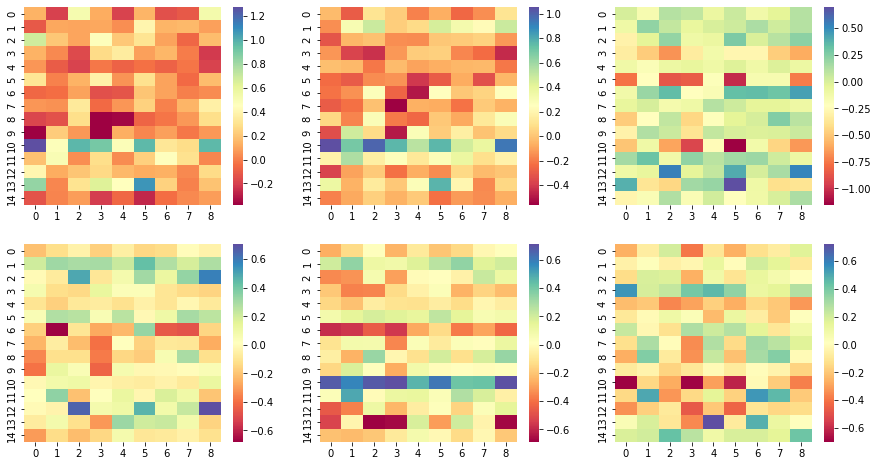

In [ ]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", str(model.state_dict()[param_tensor].size()))

wts, sets, ips = opt.visualise_weights()

l = len(wts)
wtmatrix = np.array(wts[l-1])
fig = plt.figure(figsize=(15, 8))

for i in range(6) :  #nx = 6 and m = 9

    plt.subplot(2,3,i+1)

    sns.heatmap(wtmatrix[:,i*9:i*9+9], cmap = 'Spectral')





## 7. Testing

In [6]:
#Data prepartion for test data
#colums: unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_8,s_13,s_14,s_19,RUL,labels

seq_len = 10  #sequence length for lstm
#save_path = './Results/CiRNN/'

test_arr_data = test_norm_data.copy(deep = True)
#test_arr_data.drop('label',axis=1, inplace = True)
data_test = test_arr_data.to_numpy()  #label is the last column, needed for denormalization

#data_test = smooth_data_test

list_unit = test_FD002['unit_number'].unique()


#parameters required for inverse transform (cluster statistics)
cpar1 = param1
cpar2 = param2

#parameters from train data statistics
par1 = p1[-1]  #parameter for 'RUL'  (mean/miu)
par2 = p2[-1]  #parameter for 'RUL'  (range/sigma)

#prepare the data for each engine unit grp separately
#X, Y, Z are 3 dim (num_samples,Sequence length, num_features)
#list_unit = [120]
result_rmse = []
result_r2 = []
score = []

for i in list_unit:

    grp_data = data_test[data_test[:,0] == i]
    U_test, X_test, Y_test, Z_test, Y_labels = data_preparation_test(grp_data,seq_len,1)


    test_features = torch.Tensor(X_test)
    test_targets = torch.Tensor(Y_test)
    test_cx_features = torch.Tensor(Z_test)

    test = TensorDataset(test_features,test_cx_features, test_targets)

    #test_loader = DataLoader(test, batch_size=X_test.shape[0], shuffle=False, drop_last=True)
    test_loader_one = DataLoader(test, batch_size=1, shuffle=False)


    predictions, values = opt.evaluate(test_loader_one, batch_size=1, np_features=input_dim, nc_features = context_dim)
    #flatten the multi-dimension array to 1-D array
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()

    #Apply inverse transform
    #reshape vals and preds as inverse transform accepts 2-D array

    #target_val = d_norm(np.reshape(vals,(len(vals),1)), "minmax",Y_labels,cpar1,cpar2,par1,par2)
    #pred_val = d_norm(np.reshape(preds,(len(preds),1)),"minmax",Y_labels,cpar1,cpar2,par1,par2)

    #1 level denormalise the target
    target_val = d_norm_1(np.reshape(vals,(len(vals),1)), "minmax",par1,par2)
    pred_val = d_norm_1(np.reshape(preds,(len(preds),1)),"minmax",par1,par2)

    #plot_results(i, target_val,pred_val)

    df = pd.DataFrame()
    df['Engine'] = [i] * len(target_val)
    df['Actual_RUL'] = list(target_val[0:,0])
    df['Pred_RUL'] = list(pred_val[0:,0])
    df.to_csv(save_path+ str(i) + '.csv', index = False)

    result_metrics = calculate_metrics(target_val, pred_val)  #result_metrics is a dictionary
    result_rmse.append(result_metrics['rmse'])
    result_r2.append(result_metrics['r2'])
    score.append(calculate_score(target_val, pred_val))

#calculate average and std of rmse,and score

avg_rmse = np.mean(result_rmse)
std_rmse = np.std(result_rmse)

avg_score = np.mean(score)
std_score = np.std(score)

print(f"[Average RMSE: {avg_rmse:.4f}\t Std RMSE: {std_rmse:.4f}]")
print(f"[Average SCORE: {avg_score:.4f}\t Std SCORE: {std_score:.4f}]")


min_rmse = min(result_rmse)
max_rmse = max(result_rmse)
min_score = min(score)
max_score = max(score)
print(f"[Engine unit#: {result_rmse.index(min_rmse)+1}\t Min RMSE: {min_rmse:.4f}]")
print(f"[Engine unit#: {result_rmse.index(max_rmse)+1}\t Max RMSE: {max_rmse:.4f}]")
print(f"[Engine unit#: {score.index(min_score)+1}\t Min score: {min_score:.4f}]")
print(f"[Engine unit#: {score.index(max_score)+1}\t Max score: {max_score:.4f}]")


In [5]:
print(torch.mode(torch.tensor(result_rmse),0))
print(torch.mode(torch.tensor(score),0))

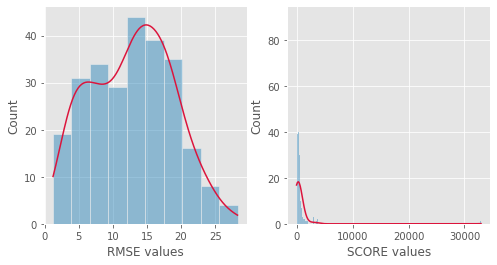

In [ ]:
#Plot the distribution of RMSE and score

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(8,4))
plot1 = sns.histplot(result_rmse, kde = 'True', ax = axes[0])
plot1.lines[0].set_color('crimson')
plot1.set(xlabel = 'RMSE values')
plot2 = sns.histplot(score, kde = 'True', ax = axes[1])
plot2.lines[0].set_color('crimson')
plot2.set(xlabel = 'SCORE values')
#plt.savefig('FD002_dist.eps', format = 'eps', dpi = 1000, Transparent = True)
plt.savefig("FD002_dist.pdf", format="pdf", dpi=1000)


### Testing (minmax normalised data)

In [7]:
#Data prepartion for test data
#colums: unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_8,s_13,s_14,s_19,RUL,labels

seq_len = 20  #sequence length for lstm



data_test = smooth_data_test

list_unit = test_FD002['unit_number'].unique()


#parameters from train data statistics
par1 = p1[-1]  #parameter for 'RUL'  (mean/miu)
par2 = p2[-1]  #parameter for 'RUL'  (range/sigma)

#prepare the data for each engine unit grp separately
#X, Y, Z are 3 dim (num_samples,Sequence length, num_features)
#list_unit = [83]
result_rmse = []
result_r2 = []
score = []

for i in list_unit:

    grp_data = data_test[data_test[:,0] == i]
    U_test, X_test, Y_test, Z_test = data_preparation(grp_data,seq_len,1)

    if len(X_test) == 0:
        continue

    test_features = torch.Tensor(X_test)
    test_targets = torch.Tensor(Y_test)
    test_cx_features = torch.Tensor(Z_test)

    test = TensorDataset(test_features,test_cx_features, test_targets)

    #test_loader = DataLoader(test, batch_size=X_test.shape[0], shuffle=False, drop_last=True)
    test_loader_one = DataLoader(test, batch_size=1, shuffle=False)


    predictions, values = opt.evaluate(test_loader_one, batch_size=1, np_features=input_dim, nc_features = context_dim)
    #flatten the multi-dimension array to 1-D array
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()

    #Apply inverse transform
    #reshape vals and preds as inverse transform accepts 2-D array

    #target_val = d_norm(np.reshape(vals,(len(vals),1)), "minmax",Y_labels,cpar1,cpar2,par1,par2)
    #pred_val = d_norm(np.reshape(preds,(len(preds),1)),"minmax",Y_labels,cpar1,cpar2,par1,par2)

    #1 level denormalise the target
    target_val = d_norm_1(np.reshape(vals,(len(vals),1)), "minmax",par1,par2)
    pred_val = d_norm_1(np.reshape(preds,(len(preds),1)),"minmax",par1,par2)

    #plot_results(i, target_val,pred_val)

    result_metrics = calculate_metrics(target_val, pred_val)  #result_metrics is a dictionary
    result_rmse.append(result_metrics['rmse'])
    result_r2.append(result_metrics['r2'])
    score.append(calculate_score(target_val, pred_val))

#calculate average and std of rmse,and score

avg_rmse = np.mean(result_rmse)
std_rmse = np.std(result_rmse)

avg_score = np.mean(score)
std_score = np.std(score)

print(f"[Average RMSE: {avg_rmse:.4f}\t Std RMSE: {std_rmse:.4f}]")
print(f"[Average SCORE: {avg_score:.4f}\t Std SCORE: {std_score:.4f}]")


min_rmse = min(result_rmse)
max_rmse = max(result_rmse)
min_score = min(score)
max_score = max(score)
print(f"[Engine unit#: {result_rmse.index(min_rmse)+1}\t Min RMSE: {min_rmse:.4f}]")
print(f"[Engine unit#: {result_rmse.index(max_rmse)+1}\t Max RMSE: {max_rmse:.4f}]")
print(f"[Engine unit#: {score.index(min_score)+1}\t Min score: {min_score:.4f}]")
print(f"[Engine unit#: {score.index(max_score)+1}\t Max score: {max_score:.4f}]")


In [8]:
print(torch.mode(torch.tensor(result_rmse),0))
print(torch.mode(torch.tensor(score),0))

In [9]:
# Test the whole data (not engine-wise)
#Data prepartion for test data

seq_len = 10  #sequence length for lstm
#cols = [0,1,2,3,4,5,6,13,18,19,24,26]   #0: unit number,1:time_cycles, 2,3,4 : 3 settings, 5,6,13,18,19: sensor data, 26:RUL
test_arr_data = test_norm_data.copy(deep = True)

#remove labels for prediction task
#test_arr_data.drop('label',axis=1, inplace = True)
data_test = test_arr_data.to_numpy()

#data_test = smooth_data_test

#parameters required for inverse transform (cluster statistics)
cpar1 = param1
cpar2 = param2

#parameters from train data statistics
par1 = p1[-1]
par2 = p2[-1]

result_rmse = []
result_r2 = []
score = []


U_test, X_test, Y_test, Z_test, Y_labels = data_preparation_test(data_test,seq_len,1)

test_features = torch.Tensor(X_test)
test_targets = torch.Tensor(Y_test)
test_cx_features = torch.Tensor(Z_test)

test = TensorDataset(test_features,test_cx_features, test_targets)

#test_loader = DataLoader(test, batch_size=X_test.shape[0], shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False)


predictions, values = opt.evaluate(test_loader_one, batch_size=1, np_features=input_dim, nc_features = context_dim)
#flatten the multi-dimension array to 1-D array
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()


#Apply denormalization transform
#reshape vals and preds as inverse transform accepts 2-D array

# target_val = d_norm(np.reshape(vals,(len(vals),1)), "minmax",Y_labels, cpar1, cpar2, par1,par2)
# pred_val = d_norm(np.reshape(preds,(len(preds),1)),"minmax",Y_labels, cpar1, cpar2,par1,par2)


target_val = d_norm_1(np.reshape(vals,(len(vals),1)), "minmax",par1,par2)
pred_val = d_norm_1(np.reshape(preds,(len(preds),1)),"minmax",par1,par2)


#plot_results(i, target_val,pred_val)

#smooth the values
#sm_pred_val = moving_average(pred_val, 10) #3 is window size

result_metrics = calculate_metrics(target_val, pred_val)  #result_metrics is a dictionary
result_rmse.append(result_metrics['rmse'])
result_r2.append(result_metrics['r2'])
score.append(calculate_score(target_val, pred_val))

print(result_rmse)
print(score)


In [10]:
# sns.set_palette("bright")
# sns.set_style("whitegrid", {'axes.grid' : False})
#plot_results(10, target_val[0:1000],pred_val[0:1000])


In [ ]:
#Plot the results Engine Unit wise
def plot_results(unit_num, target_val,pred_val):

    plt.figure(figsize=(12, 4))
    #plt.subplot(1,2,1).set_title("Engine Unit #" + str(unit_num))
    plt.subplot(1,2,1)
    plt.plot(target_val,'r')
    plt.plot(pred_val,'b')
    plt.xlabel('Time (Cycles)')
    plt.ylabel('RUL')
    plt.legend(['Actual RUL','Predicted RUL'])

#     plt.subplot(1,2,2).set_title("Engine Unit #" + str(unit_num))
#     plt.plot(target_val,pred_val,'.r')
#     plt.xlabel('Actual RUL')
#     plt.ylabel('Predcited RUL')


### Calculate Error Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(actual, predicted):

    return {'mae' : mean_absolute_error(actual,predicted),
            'rmse' : mean_squared_error(actual,predicted) ** 0.5,
            'r2' : r2_score(actual,predicted)}

# result_metrics = calculate_metrics(target_val, pred_val)
# print(result_metrics)

### Calculate Asymmetric score

In [ ]:
import math
#call this function for each unit, and sum to get the overall score
def calculate_score(actual, predicted):
#calcualate score for one engine unit
    s = 0
    a1 = 10 #constant
    a2 = 13
    s_list = []
    d_list = predicted - actual
    for i in range(len(actual)):
        d = predicted[i]-actual[i]

        if d >= 0:
            #s = s+(math.exp(d/a2)-1)
            s = (math.exp(d/a2)-1)
            s_list.append(s)

        else:

            #s = s+(math.exp(-d/a1)-1)
            s = (math.exp(-d/a1)-1)
            s_list.append(s)

#     plt.figure()
#     plt.plot(d_list,s_list,'.')

    return sum(s_list)
